In [1]:
!pip install box2d-py
!pip3 install box2d-py==2.3.8

     |████████████████████████████████| 450kB 45.4MB/s 


In [0]:
from keras.layers import Dense,Activation,Input,Add,Lambda
from keras.models import Sequential,Model
from keras.optimizers import Adam
import keras
import numpy as np
import matplotlib as mt
import gym

In [0]:
class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,n_actions,discrete=False):
    self.mem_size = max_size
    #self.input_shape = input_shape
    self.mem_cntr = 0
    self.discrete = discrete
    self.state_memory = np.zeros((self.mem_size,input_shape))
    self.new_state_memory = np.zeros((self.mem_size,input_shape))
    dtype = np.int8 if self.discrete else np.float32
    self.action_memory = np.zeros((self.mem_size,n_actions),dtype = dtype)
    self.reward_memory = np.zeros((self.mem_size))
    self.terminal_memory = np.zeros(self.mem_size,dtype = np.float32)

  def store_transition(self,state,action,reward,new_state,done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = new_state
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done)
    if self.discrete:
      actions = np.zeros(self.action_memory.shape[1])
      actions[action] = 1.0
      self.action_memory[index] = actions
    else:
      self.action_memory[index] = action
    self.mem_cntr +=1
  def sample_buffer(self,batch_size):
    max_mem = min(self.mem_cntr,self.mem_size)
    batch =np.random.choice(max_mem,batch_size)
    states = self.state_memory[batch]
    next_states = self.new_state_memory[batch]
    rewards = self.reward_memory[batch]
    actions = self.action_memory[batch]
    terminal = self.terminal_memory[batch]

    return states,actions,rewards,next_states,terminal

def build_dqn(lr,n_actions,input_dims,fc1_dims,fc2_dims):
    inputl = Input(shape=(input_dims,))
    #self.model = Sequential()
    one = Dense(24, activation="relu")(inputl)
    two=Dense(24, activation="relu")(one)
          #self.model.add(Dense(self.action_space, activation="linear"))
    state_value = Dense(1, kernel_initializer='he_uniform')(two)
    state_value = Lambda(lambda s: keras.backend.expand_dims(s[:, 0], -1), output_shape=(n_actions,))(state_value)

    action_advantage = Dense(n_actions, kernel_initializer='he_uniform')(two)
    action_advantage = Lambda(lambda a: a[:, :] - keras.backend.mean(a[:, :], keepdims=True), output_shape=(n_actions,))(action_advantage)
    X = Add()([state_value, action_advantage])
    model = Model(inputs = inputl, outputs = X, name='CartPole Dueling DDQN model')
    model.compile(loss="mse", optimizer=Adam(lr=lr))
    return model
class Agent(object):
  def __init__(self,alpha,gamma,n_actions,epsilon, batch_size,input_dims,epsilon_dec = 0.99,epsilon_end = 0.01,mem_size = 1000000,fname = 'dqn_model'):
    self.action_space = [i for i in range(n_actions)]
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_dec = epsilon_dec
    self.epsilon_min = epsilon_end
    self.batch_size = batch_size 
    self.model_name = fname

    self.memory = ReplayBuffer(mem_size,input_dims,n_actions,discrete = True)
    self.q_eval = build_dqn(alpha,n_actions,input_dims,256,256)

  def remember(self,state,action,reward,new_state,done):
    self.memory.store_transition(state,action,reward,new_state,done)

  def choose_action(self,state):
    state = state[np.newaxis,:]
    rand = np.random.random()
    if rand <self.epsilon:
      action = np.random.choice(self.action_space)
    else:
      action = self.q_eval.predict(state)
      action = np.argmax(action)
    return action

  def learn(self):
    if self.memory.mem_cntr < self.batch_size:
      return
    state,action,reward,new_state,done = self.memory.sample_buffer(self.batch_size)
    #print(action)
    action_values = np.array(self.action_space,dtype = np.int8)
    action_indices = np.dot(action,action_values)

    q_eval = self.q_eval.predict(state)
    q_next = self.q_eval.predict(new_state)
    q_target = q_eval.copy()
    batch_index = np.arange(self.batch_size,dtype = np.int32)

    q_target[batch_index,action_indices] = reward + self.gamma*np.max(q_next,axis = 1)*done
    _ = self.q_eval.fit(state,q_target,verbose =0)
    

  def save_model(self):
    self.q_eval.save(self.model_file)
  def load_model(self):
    self.q_eval = load_model(self.model_file)
  
  def epsilon_decay(self):
    self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon> self.epsilon_min else self.epsilon_min


  







In [32]:
if __name__ =='__main__':
  agent = Agent(gamma = 0.99,epsilon = 1.0,alpha = 0.0005,input_dims = 8,n_actions = 4,mem_size=1000000,batch_size = 64,epsilon_end = 0.01)

  env = gym.make('LunarLander-v2')
  score_history = []
  epsilons = []
  n_episodes = 1000
  for i in range(n_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
      action = agent.choose_action(observation)
      next_state, reward, done, info = env.step(action)
      agent.remember(observation,action,reward,next_state,done)
      agent.learn()
      observation = next_state
      score+=reward
    score_history.append(score)
    agent.epsilon_decay()
    epsilons.append(agent.epsilon)
    print('episode',i,'score:',score)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode 0 score: -238.66843324550888
episode 1 score: -203.09999590883666
episode 2 score: -315.42171707778186
episode 3 score: -194.82648561011422
episode 4 score: -113.52764691765701
episode 5 score: -227.5071074100463
episode 6 score: -217.82942890058968
episode 7 score: -127.82987945405901
episode 8 score: -151.88619006414123
episode 9 score: -217.09098126883265
episode 10 score: -204.18616250316205
episode 11 score: -98.13019889722501
episode 12 score: -156.79762218144975
episode 13 score: -239.453899739663
episode 14 score: -126.21585231134745
episode 15 score: -386.083985541206
episode 16 score: -61.637067050026594
episode 17 score: -263.81364587384724
episode 18 score: -240.2604827687225
episode 19 score: -208.8838322335953
episode 20 score: -23.54253245230973
episode 21 score: -59.35340397920041
episode 22 score: -65.41050886179505
episode 23 score: -174.01595404187026
episode 24 score: -65.70374923433927
episode 25 score: -261.61520249565086
episode 26 score: -79.940009206896

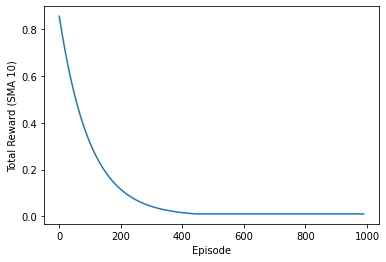

In [33]:
import matplotlib.pyplot as plt
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(epsilons[tr:tr+window]) for tr in range(window, len(epsilons))])

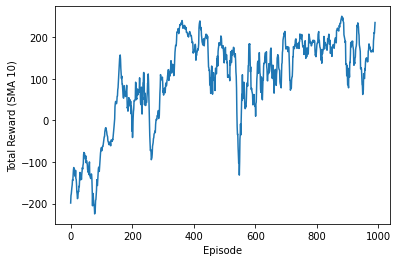

In [34]:
import matplotlib.pyplot as plt
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(score_history[tr:tr+window]) for tr in range(window, len(score_history))])